In [536]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [537]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [538]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [539]:
weight_scale = 0.5
g = 1.0

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 1.5
delay_std = delay_mean * 0.2
v_ext = 0.1

excitatory_type = "ss4"
inhibitory_type = "b"

## Generate network

In [540]:
G = nx.DiGraph()

# Add 1000 nodes
for i in range(1000):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
# excitatory_nodes = random.sample(range(1000), 800)
for i in range(800):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(800, 1000):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw m outgoing edges to random nodes
n_out = 150
for i in range(1000):
    targets = random.sample(range(1000), n_out)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
        else:
            weight = J_E
        delay = max(0.1, np.random.normal(delay_mean, delay_std))
        G.add_edge(i, target, weight=weight, distance=delay)

In [541]:
# Redistribute lognormally
G = assign_lognormal_weights_for_ntype(G, "ss4", mu=0.5, sigma=0.5, w_max=10.0)

Text(0.5, 1.0, 'ss4 Weight Distribution after Lognormal Redistribution')

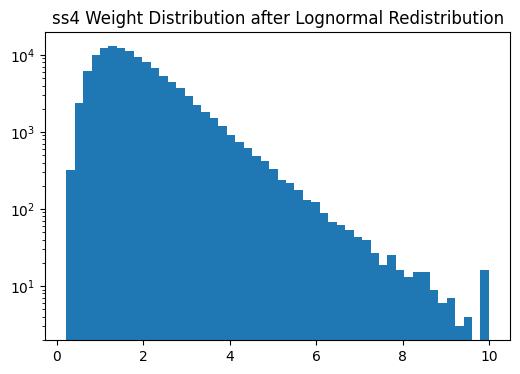

In [542]:
# Plot ss4 weight distribution
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == 'ss4']
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title("ss4 Weight Distribution after Lognormal Redistribution")

## Simulation setup

In [543]:
dt = 0.1

In [544]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [545]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

## Simulation

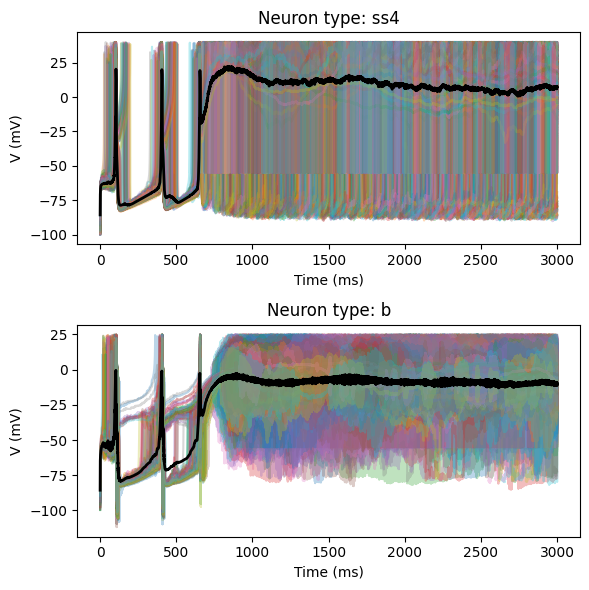

c:\Users\kingt\anaconda3\envs\neuro\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\kingt\anaconda3\envs\neuro\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<string>:76: RuntimeWarning: invalid value encountered in divide


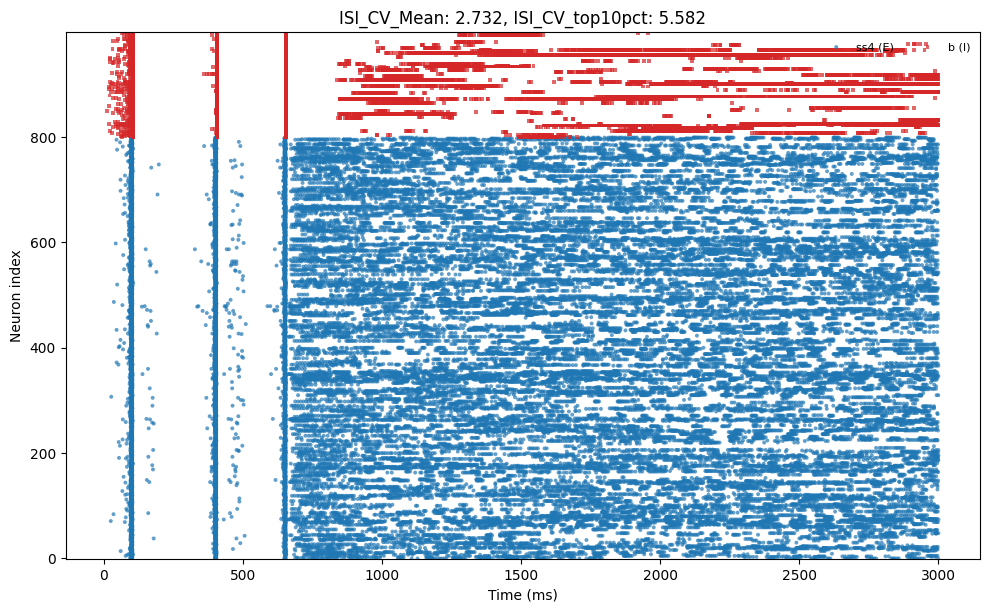

In [546]:

# Randomize initial voltages
Vs = np.random.uniform(-100, -70, size=n_neurons)
us = np.random.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0})

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=1.0)

for i in range(15000):
    sensory_spikes = poisson(dt)
    sim.step(spike_ext=sensory_spikes)

for i in range(15000):
    sim.step()

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=3000.0)

In [550]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=1000.0, t_stop_ms=3000.0)

{'rate_mean_Hz': 21.382430878456073,
 'rate_median_Hz': 10.499475026248687,
 'rate_p95_Hz': 71.996400179991,
 'ISI_CV_median': 1.7624064950195728,
 'ISI_CV_mean': 2.0973884245204983,
 'ISI_CV_mean_E': 2.074411732444704,
 'ISI_CV_mean_I': 2.3179646684481248,
 'ISI_CV_mean_top10pct': 4.632568452104,
 'refractory_violations_per_neuron': 4.956,
 'Fano_median_2ms': 0.966466466466487,
 'Fano_median_10ms': 1.3711764396897395,
 'Fano_median_50ms': 3.4444444444444446,
 'Fano_median_100ms': 4.745908889871737,
 'Fano_median_300ms': 9.046153846153846,
 'Fano_median_500ms': 12.0,
 'Fano_median_1000ms': 11.0,
 'mean_noise_corr_2ms': 0.0014480495054945788,
 'mean_noise_corr_10ms': 0.0005578547986161511,
 'mean_noise_corr_50ms': 0.0007359970346798098,
 'mean_noise_corr_100ms': 0.0008150617628165668,
 'mean_noise_corr_300ms': 0.0016742552745847644,
 'mean_noise_corr_500ms': 0.0035373983803476433,
 'mean_noise_corr_1000ms': 0.004326326322600243,
 'participation_frac_mean_300ms': 0.3705,
 'participation_

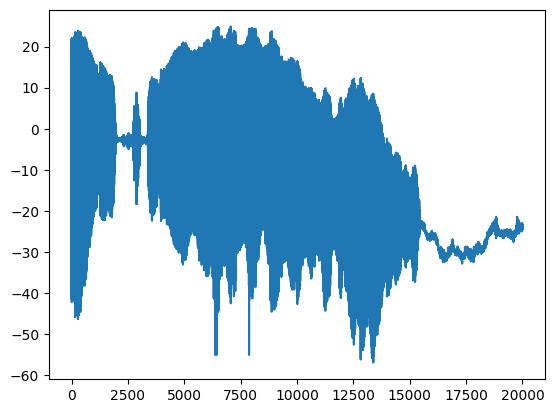

In [553]:
# Plot spikes for one neuron
plt.plot(np.array(sim.stats.Vs)[10000:,910])

In [549]:
# connectome.compute_metrics(small_world=False)